In [1]:
y = [2,3,1,4,5]
res = sorted(range(len(y)), key=lambda k: y[k])

[2, 0, 1, 3, 4]

{0.1: array([0, 1, 2, 3, 4, 5, 6, 7, 8]), 0.2: array([ 9, 10, 11]), 0.3: array([12, 13]), 0.4: array([14]), 0.5: array([15]), 0.6: array([16, 17]), 0.7: array([], dtype=int64), 0.8: array([18]), 0.9: array([19]), 1.0: array([], dtype=int64)}
[9, 3, 2, 1, 1, 2, 0, 1, 1, 0]
{0.1: 0.2233333333333333, 0.2: 0.03333333333333333, 0.3: 0.11999999999999998, 0.4: 0.42000000000000004, 0.5: 0.8099999999999999, 0.6: 0.17999999999999997, 0.7: 0, 0.8: 0.0, 0.9: 0.0, 1.0: 0}


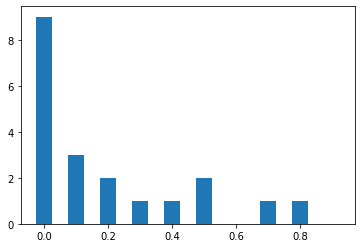

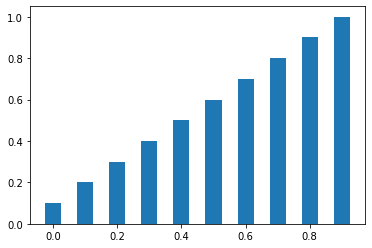

In [78]:
import numpy as np
import matplotlib.pyplot as plt
y = np.array([0.01,0.02,0.1,0.4,0.57,0.8,0.1,0.1,0.15,0.22,0.1,0.02,0.1,0.41,0.52,0.83,0.15,0.1,0.15,0.22])
y_hat = np.array([0.11,0.22,0.33,0.78,0.23,0.1,0.11,0.1,0.2,0.2,0.1,0.1,0.15,0.22,0.1,0.02,0.1,0.41,0.15,0.22])
diff = np.abs(y-y_hat)

def get_hist(y, min_value=0.0, max_value=1., step=0.1 ):
    sorted_id = sorted(range(len(y)), key=lambda k: y[k])
    y = np.array([y[i] for i in sorted_id])
    hist_index = {}
    iter_list = np.arange(min_value, max_value, step)
    for i in iter_list:
        start = i
        end = i+step
        hist_index[round(end,2)] = np.where((y>start)&(y<=end))[0]
    return hist_index, iter_list

hist_index, iter_list = get_hist(y,0.,1.,0.1)
hist_count = [len(hist_index[k]) for k in hist_index.keys()]
hist_error = {}
for key in hist_index.keys():
    hist_error[key] = np.average(diff[hist_index[key]]) if len(hist_index[key])!=0 else 0

fig = plt.figure()
plt.bar(iter_list, hist_count, width=0.05)
fig = plt.figure()
plt.bar(iter_list, hist_error, width=0.05)

